<a href="https://colab.research.google.com/github/darshlukkad/CRISP-DM_SEMMA_KDD/blob/main/CRISP_DM_Telco_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 CRISP-DM: Telco Customer Churn (End-to-End)
We will follow the six phases of **CRISP-DM** using Kaggle's **Telco Customer Churn** dataset.

**Phases**: Business Understanding → Data Understanding → Data Preparation → Modeling → Evaluation → Deployment

**Dataset**: `blastchar/telco-customer-churn` (Kaggle)

# 🚀 Step 1: One-time Kaggle setup (super easy)
1. Create a free Kaggle account (https://www.kaggle.com/).
2. Go to your Kaggle **Account** → scroll to **API** → click **Create New API Token**.
   - This downloads a file named **`kaggle.json`** to your computer.
3. In Colab, run the next cell. It will ask you to **upload `kaggle.json`**.

In [1]:
# Install and set up Kaggle API
!pip -q install kaggle

import os, zipfile, glob, shutil, json, sys
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

# Put kaggle.json in the right place
kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

if not (kaggle_dir / "kaggle.json").exists():
    try:
        from google.colab import files  # will work in Colab
        print("👉 Please upload your kaggle.json (you get it from Kaggle > Account > Create New API Token).")
        uploaded = files.upload()
        assert "kaggle.json" in uploaded, "You must upload a file named kaggle.json"
        with open(kaggle_dir / "kaggle.json", "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(kaggle_dir / "kaggle.json", 0o600)
        print("✅ Installed kaggle.json")
    except Exception as e:
        print("If you're not in Colab, manually place kaggle.json in", kaggle_dir)
        raise e
else:
    print("✅ kaggle.json already present")

👉 Please upload your kaggle.json (you get it from Kaggle > Account > Create New API Token).


Saving kaggle.json to kaggle.json
✅ Installed kaggle.json


# 📥 Step 2: Download the dataset automatically
We will use the Kaggle API to download the dataset into the local `data/` folder.
If (rarely) Kaggle blocks the download, the next cells will let you **manually upload** the CSV instead.

In [2]:
# Download the Kaggle dataset
KAGGLE_DATASET = "blastchar/telco-customer-churn"
print("⏬ Downloading:", KAGGLE_DATASET)
!kaggle datasets download -d $KAGGLE_DATASET -p $DATA_DIR --force

# Unzip any archives into data/
import zipfile, io
for z in DATA_DIR.glob("*.zip"):
    with zipfile.ZipFile(z, "r") as zip_ref:
        zip_ref.extractall(DATA_DIR)
    z.unlink()

print("📂 Contents of data/:", [p.name for p in DATA_DIR.iterdir()])

⏬ Downloading: blastchar/telco-customer-churn
Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 602MB/s]
📂 Contents of data/: ['WA_Fn-UseC_-Telco-Customer-Churn.csv']


# 🆘 If needed: Manual upload fallback
If you don't see a CSV in `data/`, run the next cell and upload the CSV from Kaggle manually.
(Go to the dataset page on Kaggle and click **Download** to get the zip; extract the CSV and upload here.)

In [3]:
from pathlib import Path
csvs = list(Path("data").glob("*.csv"))
if not csvs:
    try:
        from google.colab import files
        print("No CSV detected in data/. Please upload the CSV file now.")
        uploaded = files.upload()
        # Save the first uploaded CSV into data/
        for k, v in uploaded.items():
            if k.lower().endswith(".csv"):
                with open(Path("data")/k, "wb") as f:
                    f.write(v)
        print("✅ Uploaded CSV to data/.")
    except Exception as e:
        raise RuntimeError("Still no CSV found. Please upload a CSV to data/.") from e
else:
    print("✅ CSV already present:", [c.name for c in csvs])

✅ CSV already present: ['WA_Fn-UseC_-Telco-Customer-Churn.csv']


# 🧰 Step 3: Imports and reproducibility

In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import warnings, sys, os, re
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1) Business Understanding
**Goal:** Predict if a customer will churn (leave) next month so the company can take action.

**Success metric:** Achieve **recall ≥ 0.70** on the churn class while keeping ROC-AUC high (≥ 0.80).  
**Why recall?** We prefer catching most churners so retention offers reach them.

**Constraints:** Simple, explainable baseline + a stronger model. Inference should be quick for batch scoring.

## 2) Data Understanding
We’ll load the dataset, inspect columns, missing values, and class balance.

In [5]:
from pathlib import Path
import pandas as pd

# Try to auto-detect the Telco CSV
candidates = list(Path("data").glob("*.csv"))
csv_path = None
for p in candidates:
    if ("WA_Fn" in p.name) or ("Telco" in p.name) or ("Churn" in p.name):
        csv_path = p
        break
if csv_path is None and candidates:
    csv_path = candidates[0]

assert csv_path is not None, "No CSV found in data/. Please ensure the Telco CSV is present."
print("Using CSV:", csv_path)

df = pd.read_csv(csv_path)
print(df.head())
print(df.shape)
print(df.isna().sum().sort_values(ascending=False).head(10))
print(df['Churn'].value_counts())

Using CSV: data/WA_Fn-UseC_-Telco-Customer-Churn.csv
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSup

## 3) Data Preparation
- Drop identifiers (`customerID`)
- Fix types (e.g., `TotalCharges` sometimes has blanks → numeric)
- One-hot encode categoricals, scale numerics
- Train/validation/test split

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df2 = df.copy()

# Clean Target
df2['Churn'] = df2['Churn'].map({'Yes': 1, 'No': 0})

# TotalCharges as numeric (some blanks)
if 'TotalCharges' in df2.columns:
    df2['TotalCharges'] = pd.to_numeric(df2['TotalCharges'].replace(' ', np.nan), errors='coerce')
    df2 = df2.dropna(subset=['TotalCharges'])

# Drop obvious IDs
for col in ['customerID', 'CustomerID', 'customer_id']:
    if col in df2.columns:
        df2 = df2.drop(columns=[col])

X = df2.drop(columns=['Churn'])
y = df2['Churn']

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number', 'bool']).columns.tolist()

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)

print("Train/Valid/Test sizes:", X_train.shape, X_valid.shape, X_test.shape)

Train/Valid/Test sizes: (4922, 19) (1055, 19) (1055, 19)


## 4) Modeling
We’ll train two models:
- **Logistic Regression** (interpretable baseline)
- **Random Forest** (stronger non-linear model)

We’ll choose based on **validation** performance.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

logreg = Pipeline([('prep', preprocess),
                   ('clf', LogisticRegression(max_iter=200, class_weight='balanced', random_state=RANDOM_STATE))])

rf = Pipeline([('prep', preprocess),
               ('clf', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=RANDOM_STATE, class_weight='balanced'))])

logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

def eval_model(model, Xv, yv, name="model"):
    pred = model.predict(Xv)
    proba = model.predict_proba(Xv)[:,1]
    print(f"\n=== {name} VALIDATION ===")
    print(classification_report(yv, pred, digits=3))
    print("ROC-AUC:", roc_auc_score(yv, proba))

eval_model(logreg, X_valid, y_valid, "LogReg")
eval_model(rf, X_valid, y_valid, "RandomForest")


=== LogReg VALIDATION ===
              precision    recall  f1-score   support

           0      0.914     0.725     0.808       774
           1      0.517     0.811     0.632       281

    accuracy                          0.748      1055
   macro avg      0.715     0.768     0.720      1055
weighted avg      0.808     0.748     0.761      1055

ROC-AUC: 0.8531292817273121

=== RandomForest VALIDATION ===
              precision    recall  f1-score   support

           0      0.825     0.903     0.862       774
           1      0.639     0.473     0.544       281

    accuracy                          0.789      1055
   macro avg      0.732     0.688     0.703      1055
weighted avg      0.776     0.789     0.778      1055

ROC-AUC: 0.8202617083689665


## 5) Evaluation (Test Set)
Pick the better model (usually RF here) and evaluate on the **hold-out test set**. Plot ROC & PR curves and confusion matrix.

=== TEST REPORT (Chosen Model) ===
              precision    recall  f1-score   support

           0      0.811     0.885     0.846       775
           1      0.574     0.429     0.491       280

    accuracy                          0.764      1055
   macro avg      0.693     0.657     0.669      1055
weighted avg      0.748     0.764     0.752      1055

TEST ROC-AUC: 0.8007972350230415


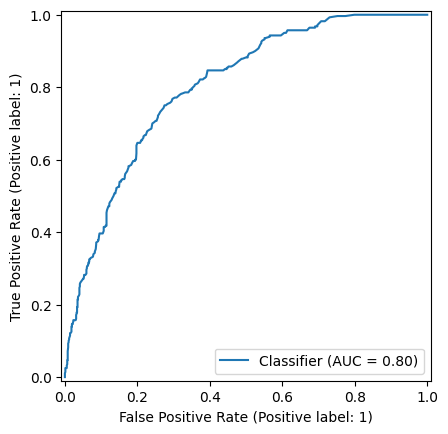

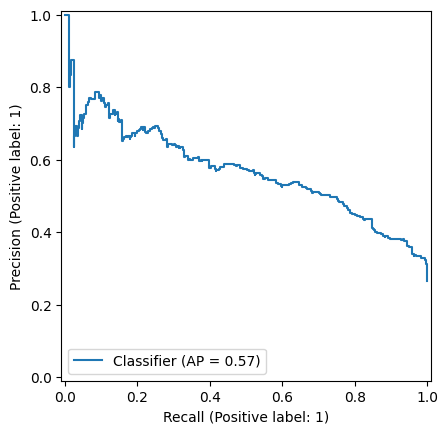

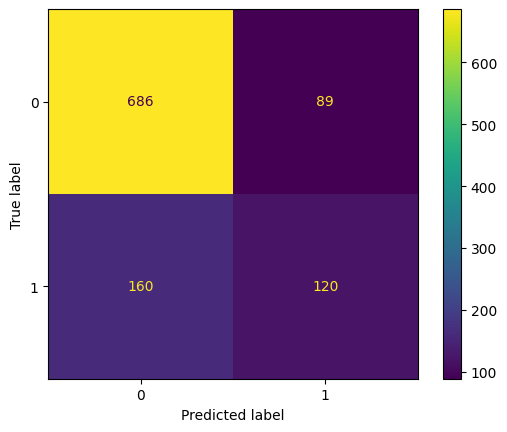

In [8]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

best = rf  # if Logistic looked better on VALIDATION, you can switch to logreg
y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)[:,1]

print("=== TEST REPORT (Chosen Model) ===")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=3))
print("TEST ROC-AUC:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

## 6) Deployment (Simple Scoring Function + Save Model)
Export the trained pipeline and provide a tiny function to score a **new customer** record (Python dict).

In [9]:
import joblib
joblib.dump(best, "telco_churn_model.joblib")
print("💾 Saved model: telco_churn_model.joblib")

# Example single prediction
example = X_test.iloc[0].to_dict()
print("Example features:", example)

def predict_single(d):
    import pandas as pd
    Xone = pd.DataFrame([d])
    return float(best.predict_proba(Xone)[:,1])

print("Predicted churn probability:", predict_single(example))
print("✅ CRISP-DM pipeline complete!")

💾 Saved model: telco_churn_model.joblib
Example features: {'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 13, 'PhoneService': 'Yes', 'MultipleLines': 'No', 'InternetService': 'Fiber optic', 'OnlineSecurity': 'No', 'OnlineBackup': 'Yes', 'DeviceProtection': 'No', 'TechSupport': 'No', 'StreamingTV': 'No', 'StreamingMovies': 'No', 'Contract': 'One year', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Mailed check', 'MonthlyCharges': 74.65, 'TotalCharges': 966.25}
Predicted churn probability: 0.23333333333333334
✅ CRISP-DM pipeline complete!


---
### 🔍 (Optional, but recommended) Ask an AI to critique each phase
Copy-paste this prompt into your favorite LLM and paste your artifacts for review:

> *"Act as a world-renowned authority on CRISP-DM who has authored award-winning books. Ruthlessly critique my **Business Understanding / Data Understanding / Data Preparation / Modeling / Evaluation / Deployment** artifacts for completeness, rigor, leakage risks, and monitoring gaps. Provide an action-prioritized fix list with concrete examples."*